In [1]:
import os

from matplotlib import pyplot as plt

import torch
import numpy as np

from ase.visualize.plot import plot_atoms
from ase import Atoms
from schnetpack import properties
import schnetpack.transform as trn
from schnetpack.datasets import QM9

from morered.datasets import QM9Filtered, TMQM
from morered.noise_schedules import CosineSchedule, PolynomialSchedule, LinearSchedule
from morered.processes import VPGaussianDDPM
from morered.transform import Diffuse
from morered.utils import scatter_mean

# Prepare the data

Define paths

In [2]:
tut_path = "./tut"

# path to store the dataset as ASE '.db' files
datapath = os.path.join(tut_path, "tmqm.db") 

# path to store the dataset as ASE '.db' files
split_file_path = os.path.join(tut_path, "split.npz") 

# path to store a mapping between the DB indices and the number of atoms. Needed for filtered loading from the dataset
indices_path = os.path.join(tut_path, "n_atoms_indices.pkl") 

In [3]:
os.makedirs(tut_path, exist_ok=True)

Define data input transformations

In [4]:
transforms=[
    trn.CastTo64(),
    trn.SubtractCenterOfGeometry(),
]

Define dataset and dataloaders

In [7]:
qm9data = QM9Filtered(
    datapath=datapath,
    batch_size=8,
    n_atoms_allowed=None,
    shuffle_train=True,
    n_overfit_molecules=None,
    permute_indices=False,
    repeat_indices=None,
    remove_uncharacterized=True,
    num_train=128,
    num_val=128,
    num_test=128,
    transforms=transforms,
    property_units={QM9.U0: 'eV'},
    num_workers=2,
    split_file=split_file_path,
    indices_path=indices_path,
    pin_memory=False,
    load_properties=[QM9.U0]
)

In [28]:
tmqmdata = TMQM(
    datapath=datapath,
    batch_size=8,
    num_train=128,
    num_val=128,
    num_test=128,
    transforms=transforms,
    property_units={TMQM.energy: 'eV'},
    num_workers=2,
    split_file=split_file_path,
    pin_memory=False,
    load_properties=[TMQM.energy]
)

qm9data = tmqmdata

In [29]:
# prepare and setup the dataset
qm9data.prepare_data()
qm9data.setup()

Load and plot an example batch

In [30]:
batch = next(iter(qm9data.train_dataloader()))

In [8]:
batch.keys()

dict_keys(['_idx', 'Electronic_E', '_n_atoms', '_atomic_numbers', '_positions', '_cell', '_pbc', '_idx_m'])

In [12]:
bonds1 = {
    "H": {
        "H": 74,
        "C": 109,
        "N": 101,
        "O": 96,
        "F": 92,
        "B": 119,
        "Si": 148,
        "P": 144,
        "As": 152,
        "S": 134,
        "Cl": 127,
        "Br": 141,
        "I": 161,
    },
    "C": {
        "H": 109,
        "C": 154,
        "N": 147,
        "O": 143,
        "F": 135,
        "Si": 185,
        "P": 184,
        "S": 182,
        "Cl": 177,
        "Br": 194,
        "I": 214,
    },
    "N": {
        "H": 101,
        "C": 147,
        "N": 145,
        "O": 140,
        "F": 136,
        "Cl": 175,
        "Br": 214,
        "S": 168,
        "I": 222,
        "P": 177,
    },
    "O": {
        "H": 96,
        "C": 143,
        "N": 140,
        "O": 148,
        "F": 142,
        "Br": 172,
        "S": 151,
        "P": 163,
        "Si": 163,
        "Cl": 164,
        "I": 194,
    },
    "F": {
        "H": 92,
        "C": 135,
        "N": 136,
        "O": 142,
        "F": 142,
        "S": 158,
        "Si": 160,
        "Cl": 166,
        "Br": 178,
        "P": 156,
        "I": 187,
    },
    "B": {"H": 119, "Cl": 175},
    "Si": {
        "Si": 233,
        "H": 148,
        "C": 185,
        "O": 163,
        "S": 200,
        "F": 160,
        "Cl": 202,
        "Br": 215,
        "I": 243,
    },
    "Cl": {
        "Cl": 199,
        "H": 127,
        "C": 177,
        "N": 175,
        "O": 164,
        "P": 203,
        "S": 207,
        "B": 175,
        "Si": 202,
        "F": 166,
        "Br": 214,
    },
    "S": {
        "H": 134,
        "C": 182,
        "N": 168,
        "O": 151,
        "S": 204,
        "F": 158,
        "Cl": 207,
        "Br": 225,
        "Si": 200,
        "P": 210,
        "I": 234,
    },
    "Br": {
        "Br": 228,
        "H": 141,
        "C": 194,
        "O": 172,
        "N": 214,
        "Si": 215,
        "S": 225,
        "F": 178,
        "Cl": 214,
        "P": 222,
    },
    "P": {
        "P": 221,
        "H": 144,
        "C": 184,
        "O": 163,
        "Cl": 203,
        "S": 210,
        "F": 156,
        "N": 177,
        "Br": 222,
    },
    "I": {
        "H": 161,
        "C": 214,
        "Si": 243,
        "N": 222,
        "O": 194,
        "S": 234,
        "F": 187,
        "I": 266,
    },
    "As": {"H": 152},
}

bonds2 = {
    "C": {"C": 134, "N": 129, "O": 120, "S": 160},
    "N": {"C": 129, "N": 125, "O": 121},
    "O": {"C": 120, "N": 121, "O": 121, "P": 150},
    "P": {"O": 150, "S": 186},
    "S": {"P": 186},
}


bonds3 = {
    "C": {"C": 120, "N": 116, "O": 113},
    "N": {"C": 116, "N": 110},
    "O": {"C": 113},
}

allowed_bonds_dict = {
    "H": 1,
    "C": 4,
    "N": 3,
    "O": 2,
    "F": 1,
    "B": 3,
    "Al": 3,
    "Si": 4,
    "S": 4,
    "Cl": 1,
    "As": 3,
    "Br": 1,
    "I": 1,
}


In [14]:
from tqdm import tqdm
import pickle

def squared_euclidean_distance(a, b):
    """
    Efficiently compute the squared Euclidean distance between two sets of points.

    Args:
        a: first set of points
        b: second set of points
    """
    distance = (
        (a**2).sum(axis=1)[:, None] - 2 * np.dot(a, b.T) + (b**2).sum(axis=1)[None]
    )

    return np.where(distance < 0, np.zeros(distance.shape), distance)


def check_validity(
    inputs,
    m_bonds_1,
    m_bonds_2,
    m_bonds_3,
    allowed_bonds,
    bonds_relaxation=None,
    progress_bar=True,
):
    """
    Fast check for the validity of molecules in a batch, including mol connectivity.

    Args:
        inputs: batch of molecules
        m_bonds_1: matrix of covalent radii for single bonds
        m_bonds_2: matrix of covalent radii for double bonds
        m_bonds_3: matrix of covalent radii for triple bonds
        allowed_bonds: number of allowed bonds per atom
        bonds_relaxation: relaxation coefficients for the covalent radii
        progress_bar: show tqsm progress bar
    """
    # set default covalent radii relaxation coefficients
    bonds_relaxation = bonds_relaxation or [0.1, 0.05, 0.03]

    bonds = []
    stable_atoms = []
    stable_molecules = []
    stable_atoms_wo_h = []
    stable_molecules_wo_h = []
    connected = []
    connected_wo_h = []

    # create idx_m if one system is given
    if properties.idx_m not in inputs:
        inputs[properties.idx_m] = torch.zeros(
            len(inputs[properties.Z]), dtype=torch.int32
        )
        progress_bar = False

    # loop over molecules in the batch
    for m in tqdm(inputs[properties.idx_m].unique(), disable=not progress_bar):
        # get the atomic numbers and positions for the current molecule
        mask = inputs[properties.idx_m] == m
        R = inputs[properties.R][mask]
        Z = inputs[properties.Z][mask]
        if torch.is_tensor(R):
            R = R.detach().cpu().numpy()
        if torch.is_tensor(Z):
            Z = Z.detach().cpu().numpy()

        # get covalent radii for the atoms in the current molecule
        ex_bonds_1 = m_bonds_1[Z[None], Z[:, None]]
        ex_bonds_2 = m_bonds_2[Z[None], Z[:, None]]
        ex_bonds_3 = m_bonds_3[Z[None], Z[:, None]]

        # compute distance matrix
        dist = squared_euclidean_distance(R, R) ** 0.5
        np.fill_diagonal(dist, np.inf)

        # get bond types per atom
        bonds_ = np.where(dist < ex_bonds_1 + bonds_relaxation[0], 1, 0)
        bonds_ = np.where(dist < ex_bonds_2 + bonds_relaxation[1], 2, bonds_)
        bonds_ = np.where(dist < ex_bonds_3 + bonds_relaxation[2], 3, bonds_)

        bonds.append(bonds_)

        # check if molecule is stable
        total_bonds = bonds_.sum(1)
        stable_at = allowed_bonds[Z] == total_bonds
        stable_atoms.append(stable_at)
        stable_molecules.append(stable_at.all())

        # check if molecule is stable without hydrogen
        stable_at[Z == 1] = True
        stable_atoms_wo_h.append(stable_at)
        stable_molecules_wo_h.append(stable_at.all())

        # check if ALL the molecule is connected
        # using the exponent of the adjacency matrix trick
        bonds_t = (bonds[-1]) + np.eye(bonds[-1].shape[0])
        bonds_t = bonds_t > 0
        for i in range(bonds_t.shape[0]):
            bonds_t = bonds_t.dot(bonds_t)
        connected.append(bonds_t.all(1).any())

        # check if molecule is connected without hydrogen
        bonds_t[:, Z == 1] = True
        connected_wo_h.append(bonds_t.all(1).any())

    results = {
        "bonds": bonds,
        "stable_atoms": stable_atoms,
        "stable_molecules": stable_molecules,
        "connected": connected,
        "stable_atoms_wo_h": stable_atoms_wo_h,
        "stable_molecules_wo_h": stable_molecules_wo_h,
        "connected_wo_h": connected_wo_h,
    }

    return results


def generate_bonds_data(save_path= None, overwrite: bool = False):
    """
    generate the bonds data as connectivity matrix between possible atoms.

    Args:
        save_path: path to save the data
        overwrite: overwrite existing data
    """
    save_path = save_path or "./bonds.pkl"

    if os.path.exists(save_path) and not overwrite:
        with open(save_path, "rb") as f:
            return pickle.load(f)

    atoms = np.array(chemical_symbols)
    indices = np.arange(len(atoms))
    m_bonds_1 = np.ones((len(atoms), len(atoms))) * -np.inf
    m_bonds_2 = m_bonds_1.copy()
    m_bonds_3 = m_bonds_1.copy()
    allowed_bonds = np.zeros((len(atoms)), dtype=np.int32)

    # define the bonds types and allowed bonds per atom
    for at in atoms:
        for at2 in atoms:
            if at in bonds1 and at2 in bonds1[at]:
                m_bonds_1[indices[atoms == at], indices[atoms == at2]] = (
                    bonds1[at][at2] / 100.0
                )
            if at in bonds2 and at2 in bonds2[at]:
                m_bonds_2[indices[atoms == at], indices[atoms == at2]] = (
                    bonds2[at][at2] / 100.0
                )
            if at in bonds3 and at2 in bonds3[at]:
                m_bonds_3[indices[atoms == at], indices[atoms == at2]] = (
                    bonds3[at][at2] / 100.0
                )
        if at in allowed_bonds_dict:
            allowed_bonds[indices[atoms == at]] = allowed_bonds_dict[at]

    data = {
        "bonds_1": m_bonds_1,
        "bonds_2": m_bonds_2,
        "bonds_3": m_bonds_3,
        "allowed_bonds": allowed_bonds,
    }

    with open(save_path, "wb") as f:
        pickle.dump(data, f)

    return data

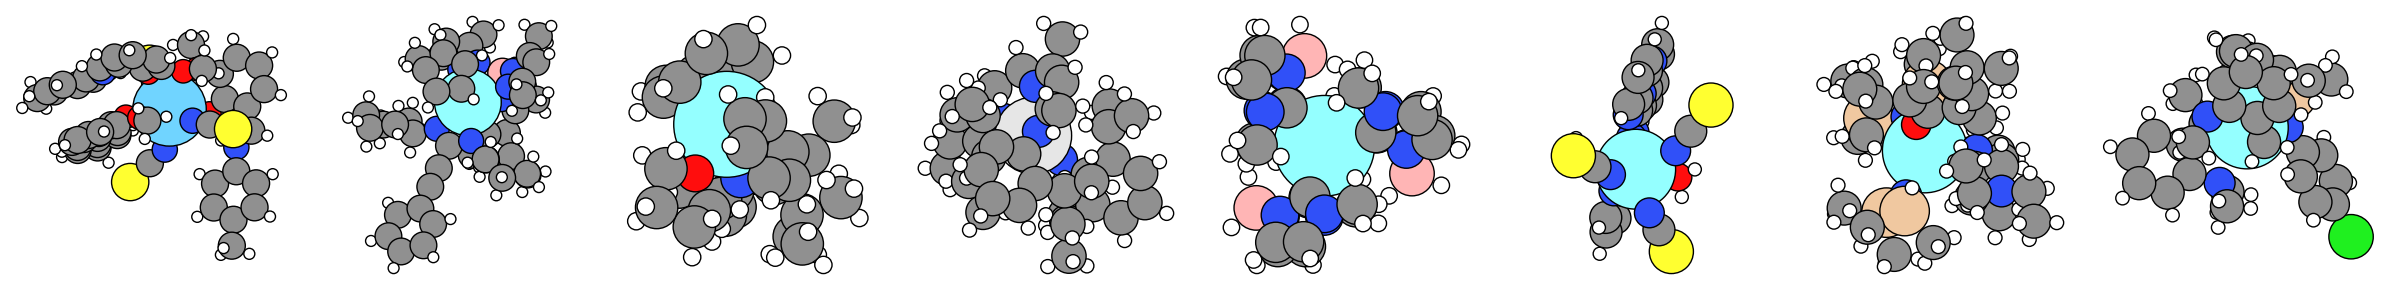

In [31]:
n_cols = 8
n_rows = 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()

for i, ax in enumerate(axs):
    mask = batch[properties.idx_m] == i
    mol = Atoms(numbers=batch[properties.Z][mask], positions=batch[properties.R][mask])

    plot_atoms(mol, ax, rotation=("0x,0y,0z"))
    ax.axis("off")

plt.tight_layout()
plt.show()

In [32]:
validity = check_validity(batch, *generate_bonds_data().values(), progress_bar=False)
validity['stable_molecules'] ,[np.mean(x) for x in validity['stable_atoms']]

([False, False, False, False, False, False, False, False],
 [0.8073394495412844,
  0.9047619047619048,
  0.8125,
  0.8921568627450981,
  0.8026315789473685,
  0.6730769230769231,
  0.9274193548387096,
  0.7901234567901234])

# Noise Schedules

Define example schedules

In [20]:
# define the noise schedules 
polynomial_schedule = PolynomialSchedule(T=1000, s=1e-5, dtype=torch.float64, variance_type="lower_bound")
cosine_schedule = CosineSchedule(T=1000, s=0.008, v=1., variance_type="lower_bound")
cosine_schedule_vignac = CosineSchedule(T=1000, s=0.008, v=2.5, variance_type="lower_bound")
linear_schedule = LinearSchedule(T=1000, variance_type="lower_bound")

step = 10
x = np.arange(0, polynomial_schedule.T, step)

Plot the schedules

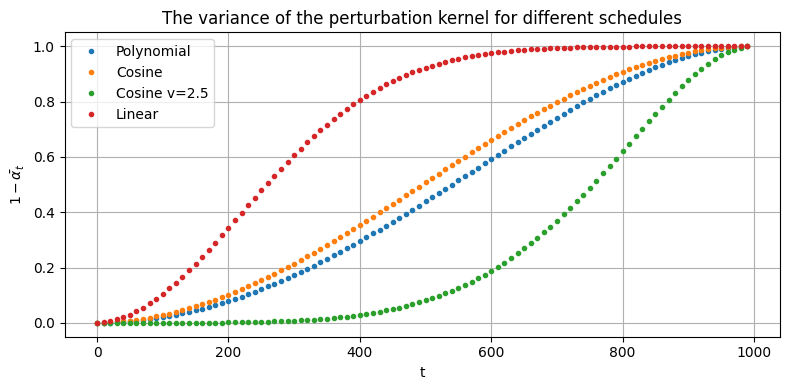

In [21]:
plt.figure(figsize=(8, 4))

plt.plot(x, polynomial_schedule.betas_bar[::step], '.', label="Polynomial")
plt.plot(x, cosine_schedule.betas_bar[::step], '.', label="Cosine")
plt.plot(x, cosine_schedule_vignac.betas_bar[::step], '.', label="Cosine v=2.5")
plt.plot(x, linear_schedule.betas_bar[::step], '.', label="Linear")

plt.xlabel(r"t")
plt.ylabel(r"$1-\bar{\alpha_t}$")
plt.title("The variance of the perturbation kernel for different schedules")

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

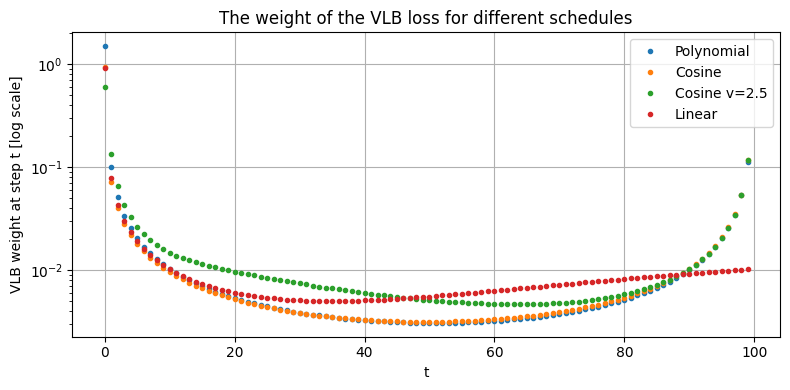

In [12]:
# plot the vlb weight for all schedules
plt.figure(figsize=(8, 4))

plt.plot(polynomial_schedule.vlb_weights[::step], '.', label="Polynomial")
plt.plot(cosine_schedule.vlb_weights[::step], '.', label="Cosine")
plt.plot(cosine_schedule_vignac.vlb_weights[::step], '.', label="Cosine v=2.5")
plt.plot(linear_schedule.vlb_weights[::step], '.', label="Linear")

plt.yscale("log")

plt.xlabel("t")
plt.ylabel("VLB weight at step t [log scale]")
plt.title("The weight of the VLB loss for different schedules")

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Variance-Preserving Gaussian diffusion

Define the diffusion process

In [33]:
# define the noise schedule
noise_schedule = PolynomialSchedule(T=1000, s=1e-5, dtype=torch.float64, variance_type="lower_bound")

# define the forward diffusion process
ddpm = VPGaussianDDPM(noise_schedule, noise_key="eps", invariant=True, dtype=torch.float64)

Simulate the forward trajectory for one example molecule

In [34]:
# fetch an example molecule
mol = qm9data.train_dataset[5]
x = mol[properties.R]

# Get the whole diffusion trajectory
timesteps = torch.arange(1000).unsqueeze(-1).unsqueeze(-1)
x_t, noise = ddpm.diffuse(x, None, timesteps)

x_t.shape, noise.shape

(torch.Size([1000, 105, 3]), torch.Size([1000, 105, 3]))

In [35]:
# check if the centre of geometry for the molecule and noise is zero
assert (x_t.mean(-2) < 1e-15).all() and (noise.mean(-2) < 1e-15).all()

plot the diffusion trajectory

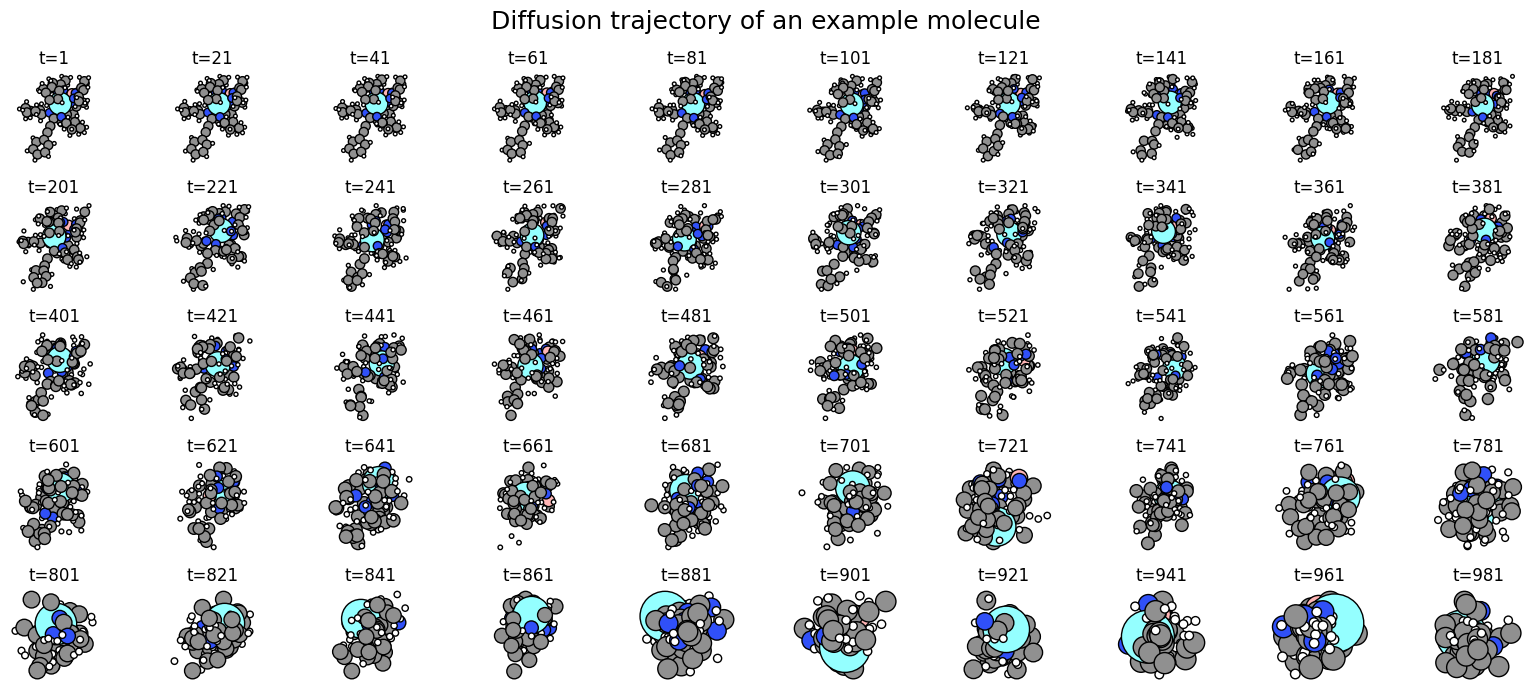

In [36]:
fig, axs = plt.subplots(5, 10, figsize=(16, 7))
axs = axs.flatten()

for i, t in enumerate(range(0,1000,20)):
    diffused_R = x_t[t]
    Z = mol[properties.Z]
    m = Atoms(positions=diffused_R, numbers=Z)
    
    plot_atoms(m, ax=axs[i])
    axs[i].axis("off")
    axs[i].set_title(f"t={t+1}")

plt.suptitle("Diffusion trajectory of an example molecule", fontsize=18)
plt.tight_layout()
plt.show()

# Diffusion as input transformation for data loader

Redefine the input transformations

In [15]:
transforms=[
    trn.CastTo64(),
    trn.SubtractCenterOfGeometry(),
    Diffuse(
        diffuse_property = properties.R,
        diffusion_process= ddpm,
        T= 1000,
        time_key = "t"
    )
]

In [16]:
qm9data = QM9Filtered(
    datapath=datapath,
    batch_size=8,
    n_atoms_allowed=None,
    shuffle_train=True,
    n_overfit_molecules=None,
    permute_indices=False,
    repeat_indices=None,
    remove_uncharacterized=True,
    num_train=128,
    num_val=128,
    num_test=128,
    transforms=transforms,
    property_units={QM9.U0: 'eV'},
    num_workers=2,
    split_file=split_file_path,
    indices_path=indices_path,
    pin_memory=False,
    load_properties=[QM9.U0]
)

In [17]:
# prepare and setup the dataset
qm9data.prepare_data()
qm9data.setup()

Load and plot an example of diffused batch

In [18]:
batch = next(iter(qm9data.train_dataloader()))

In [19]:
batch.keys()

dict_keys(['_idx', 'energy_U0', '_n_atoms', '_atomic_numbers', '_positions', '_cell', '_pbc', 'original__positions', 'eps', 't', '_idx_m'])

In [22]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-15).all()
assert (scatter_mean(batch["eps"], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-15).all()

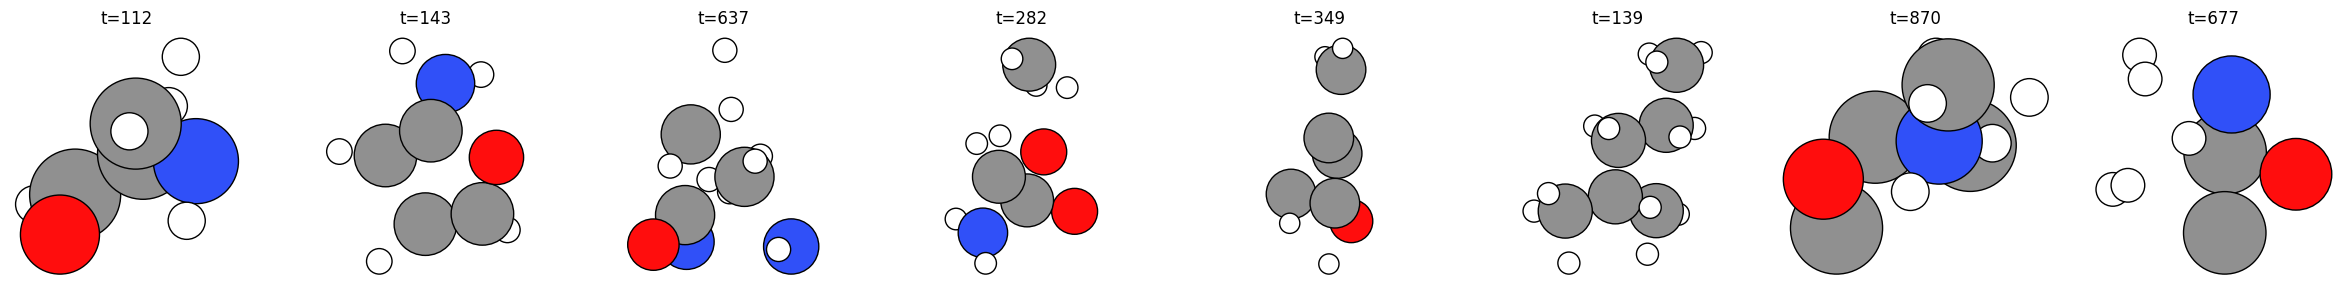

In [23]:
n_cols = 8
n_rows = 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()

for i, ax in enumerate(axs):
    mask = batch[properties.idx_m] == i
    mol = Atoms(numbers=batch[properties.Z][mask], positions=batch[properties.R][mask])

    plot_atoms(mol, ax, rotation=("0x,0y,0z"))
    ax.axis("off")

    t = batch["t"][mask]
    t = t.unique()
    t = t * (noise_schedule.T-1)
    t = t.long().item()

    ax.set_title(f"t={t}")

plt.tight_layout()
plt.show()